# Capstone Project-Investment and Trading 

The code in this ipython notebook is based on Machine Learning for Trading class offered by Udacity. 
This project aims to predict stock price of a portfolio that would give the maximum Sharpe ration in the given period of time that the client wants to sell. 

The input of this project is ticker symbols, start_date, and end_date. 
The intermediate output is the optimal ratio of each stock in a portfolio that is predicted to make maximum Sharpe ratio for 7 days, 1month, 3month, 6month, and 1 year. 
The ultimate output is the proposal of cumulative return for that porfolio with many different sets of optimal ratio for diffenrent investment period. 

**Step 1.** The stock price data for several ticker symbols are downloaded from Yahoo! Finance in the current working directory. User can give upto 5 ticker symbols. Start_date, end_date is user's choice. For the testing purpose, end_date should incorportate the date that train

**Step 2.** 


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%matplotlib inline 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import urllib
import math
import datetime as dt
from datetime import datetime
from pandas import datetime
import scipy.optimize as spo
from scipy.spatial import distance
from sklearn.model_selection import TimeSeriesSplit
import datetime
import matplotlib.finance as finance
from IPython.display import display


os.getcwd()

'/Users/parksoy/Desktop/GoogleDrive_Soyoung/Udacity_nanoDegree_MachineLearning/capstone'

In [3]:
#utils

def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method="ffill", inplace=True)
    df_data.fillna(method="bfill", inplace=True)
    
def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(symbol))

def get_data(symbols, dates):
    """Read adjusted close only for given symbols from CSV files."""
    df_final = pd.DataFrame(index=dates)
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
        file_path = symbol_to_path(symbol)
        df_temp = pd.read_csv(file_path,parse_dates=True,index_col="Date", usecols=["Date", "Adj Close"],na_values=["nan"])
        df_temp = df_temp.rename(columns={"Adj Close": symbol})
        df_final = df_final.join(df_temp)
        if symbol == "SPY":  # drop dates SPY did not trade
            df_final = df_final.dropna(subset=["SPY"])
    return df_final

def normarlize_data(df):
    return df/df.ix[0,:]

def plot_data(df_data,title="Stock Data",xlabel="Date",ylabel="Price"):
    """Plot stock data with appropriate axis labels."""
    ax = df_data.plot(title=title, fontsize=7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend(loc="best", fontsize=4)
    plt.show()

def plot_selected(df, columns, start_index, end_index):
    """Plot the desired columns over index values in the given range."""
    df_plot=df.ix[end_index:start_index,columns]
    df_plot=normarlize_data(df_plot)
    plot_data(df_plot, title='Selected Stock Prices')

def plot_normalized_data(df, title, xlabel, ylabel):
    #Normalize given stock prices and plot for comparison.
    #This is used to create a chart that illustrates the value of your portfolio over the year and compares it to SPY.
    #Note: Before plotting, portfolio and SPY values should be normalized to 1.0 at the beginning of the period.
    #Also, use the plot_data() utility function to generate and show your plot.
    df=normarlize_data(df)
    plot_data(df, title=title, ylabel="Normalized value")

#indicators

def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    # TODO: Compute upper_band and lower_band
    upper_band=rm+2*rstd
    lower_band=rm-2*rstd
    
    return upper_band, lower_band


#http://matplotlib.org/examples/pylab_examples/finance_work2.html
def moving_average(x, n, type='simple'):
    """compute an n period moving average.type is 'simple' | 'exponential'"""
    x_np = np.asarray(x)
    if type == 'simple': weights = np.ones(n)
    else: weights = np.exp(np.linspace(-1., 0., n))
    weights /= weights.sum()
    a = np.convolve(x_np, weights, mode='full')[:len(x_np)]
    a[:n] = a[n]
    a=pd.Series(a, index=x.index, name=type+" Moving Average")
    return a

def relative_strength(prices, n=14):
    """compute the n period relative strength indicator"""
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)
    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
        rsi=pd.Series(rsi,index=prices.index,name="RSI")
    return rsi

def moving_average_convergence(x, nslow=26, nfast=12):
    """ compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    emaslow=pd.Series(emaslow, index=x.index, name="emaslow")
    emafast=pd.Series(emafast, index=x.index, name="emafast")
    return emaslow, emafast, emafast - emaslow


# 1. Data preprocessing

# 1-1. Download features/fundamental indicators for Intel and saved as csv. 

In [4]:
df_feature=pd.read_csv('./data/INTC_feature.csv',parse_dates=True,index_col="Period",na_values=["nan"]) #, usecols=["Date", "Adj Close"]
df_feature.head(5)   

,Intel 14-Day Relative Strength Index,Intel 30-Day Average Daily Volume,Intel Accounts Payable (Annual),Intel EBITDA (TTM),Intel EPS Basic (TTM),Intel Enterprise Value,Intel Gross Profit (Annual),Intel Market Cap,Intel Net Income (TTM),Intel PE Ratio (TTM),Intel Quick Ratio (Quarterly),Intel Total Assets (Quarterly),Intel Total Current Assets (Quarterly),Intel Total Return Price (Forward Adjusted),Intel Volume
Period,,,,,,,,,,,,,,,
2017-03-09,44.3881,2.578581e+07,NaN,NaN,NaN,177934.98,NaN,169750.98,NaN,16.9763,NaN,NaN,NaN,52.801847,23606272.0
2017-03-08,40.5449,2.607681e+07,NaN,NaN,NaN,176987.18,NaN,168803.18,NaN,16.8815,NaN,NaN,NaN,52.507029,20908071.0
2017-03-07,43.0301,2.655048e+07,NaN,NaN,NaN,177840.20,NaN,169656.20,NaN,16.9668,NaN,NaN,NaN,52.772365,23423844.0
2017-03-06,38.5619,2.669468e+07,NaN,NaN,NaN,176750.23,NaN,168566.23,NaN,16.8578,NaN,NaN,NaN,52.433325,24405135.0
2017-03-03,43.0615,2.667842e+07,NaN,NaN,NaN,178314.10,NaN,170130.10,NaN,17.0142,NaN,NaN,NaN,52.919774,17539388.0


In [5]:
df_feature.tail(5)

,Intel 14-Day Relative Strength Index,Intel 30-Day Average Daily Volume,Intel Accounts Payable (Annual),Intel EBITDA (TTM),Intel EPS Basic (TTM),Intel Enterprise Value,Intel Gross Profit (Annual),Intel Market Cap,Intel Net Income (TTM),Intel PE Ratio (TTM),Intel Quick Ratio (Quarterly),Intel Total Assets (Quarterly),Intel Total Current Assets (Quarterly),Intel Total Return Price (Forward Adjusted),Intel Volume
Period,,,,,,,,,,,,,,,
1997-01-08,64.2257,1.095699e+07,NaN,NaN,NaN,109997.250,NaN,116787.250,NaN,24.0287,NaN,NaN,NaN,18.018356,15688800.0
1997-01-07,66.2354,1.075075e+07,NaN,NaN,NaN,110920.875,NaN,117710.875,NaN,24.2188,NaN,NaN,NaN,18.160856,12004000.0
1997-01-06,61.7951,1.075004e+07,NaN,NaN,NaN,107226.375,NaN,114016.375,NaN,23.4586,NaN,NaN,NaN,17.590855,15068700.0
1997-01-03,61.2696,1.066234e+07,NaN,NaN,NaN,106815.875,NaN,113605.875,NaN,23.3742,NaN,NaN,NaN,17.527522,11948600.0
1997-01-02,51.3219,1.063838e+07,NaN,NaN,NaN,100247.875,NaN,107037.875,NaN,22.0228,NaN,NaN,NaN,16.514187,12195300.0


In [6]:
fill_missing_values(df_feature)

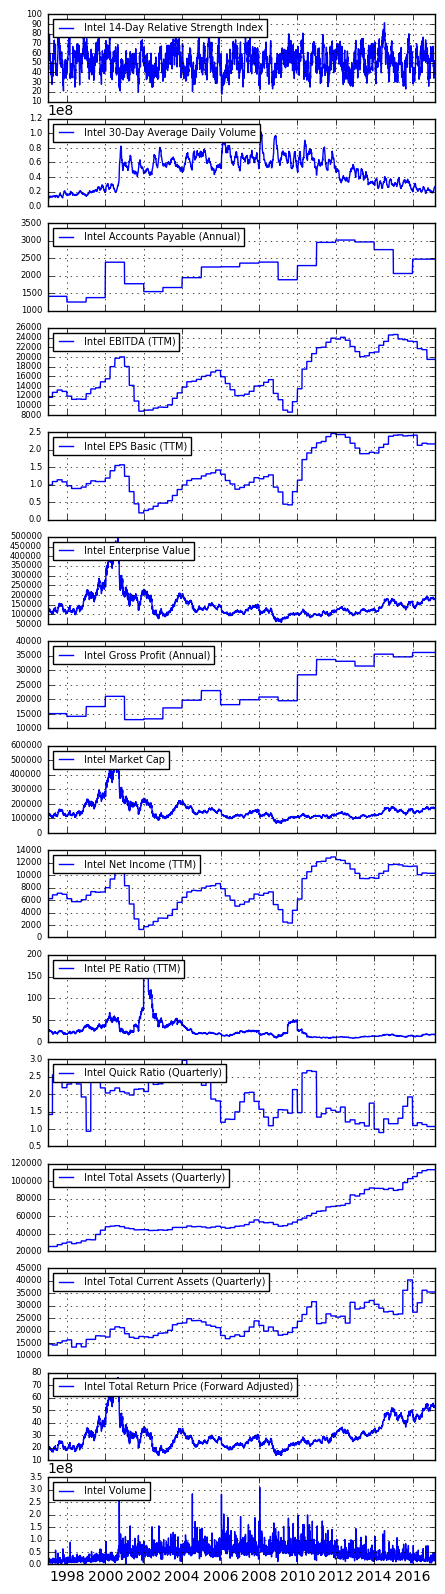

In [7]:
plt.rcParams['figure.figsize'] = (5.0, 20.0)
f, ax = plt.subplots(nrows=len(df_feature.columns),sharex=True) #,ncols=len(df_feature.columns)/2

for i,colname in enumerate(df_feature.columns):
    ax[i].plot(df_feature[colname])
    ax[i].grid(True)
    ax[i].legend(loc='upper left',fontsize=7)
    ax[i].set_ylabel("")
    ax[i].tick_params(axis='y', which='major', labelsize=6)

plt.show()

## 1-2. Download daily SPY(S&P 500) data, Intel open,close,adj close value from Yahoo! Finance

In [8]:
#INPUT as global
symbols = ['INTC']
start_date = dt.datetime(1997,1,1)
end_date = dt.datetime(2017,3,9)

#download latest dataset with symbol from Yahoo Finance

def fetch_data(symbol,start_date,end_date):
    """ Downloads .csv files for <symbols> from Yahoo Finance and saves them in 'data' directory."""

    time_frame = "m" # d -> daily, w -> weekly, m -> monthly.
      
    start_date_mm=str(start_date.month-1)
    start_date_yyyy=str(start_date.year)
    start_date_dd=str(start_date.day)
    
    end_date_mm=str(end_date.month-1)
    end_date_yyyy=str(end_date.year)
    end_date_dd=str(end_date.day)

    url="http://real-chart.finance.yahoo.com/table.csv?s="+\
        symbol+\
        "&a="+start_date_mm+"&b="+start_date_dd+"&c="+start_date_yyyy+\
        "&d="+end_date_mm+"&e="+end_date_dd+"&f="+end_date_yyyy+\
        "&g="+time_frame+"+&ignore=.csv"

    csvfile,_=urllib.urlretrieve(url, './data/{}.csv'.format(symbol))
    print "Downloading for "+symbol
    print "URL:"+url
    statinfo = os.stat(csvfile)
    print 'File size:', statinfo.st_size/1000,"KB"

def run():
    #Download csv for symbols
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
       fetch_data(symbol,start_date,end_date)
    
run()

URL:http://real-chart.finance.yahoo.com/table.csv?s=SPY&a=0&b=1&c=1997&d=2&e=9&f=2017&g=m+&ignore=.csv
File size: 362 KB
URL:http://real-chart.finance.yahoo.com/table.csv?s=INTC&a=0&b=1&c=1997&d=2&e=9&f=2017&g=m+&ignore=.csv
File size: 310 KB


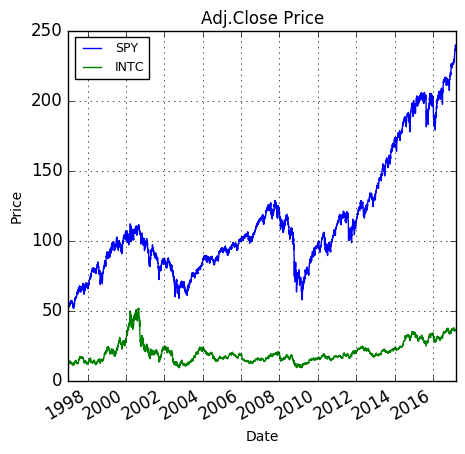

In [9]:
# Read data
plt.rcParams['figure.figsize'] = (5.0, 5.0)
dates = pd.date_range(start_date, end_date)
df_price = get_data(symbols, dates)
title="Adj.Close Price"; xlabel="Date"; ylabel="Price"
ax = df_price.plot(title=title, fontsize=12)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(True)
ax.legend(loc="best", fontsize=9)
plt.show()

In [10]:
df_price.head(5)

,SPY,INTC
1997-01-02,51.810823,11.206980
1997-01-03,52.554415,11.894656
1997-01-06,52.095175,11.937636
1997-01-07,52.729378,12.324454
1997-01-08,52.270138,12.227750


In [11]:
df_price.tail(5)

,SPY,INTC
2017-03-03,238.419998,35.900002
2017-03-06,237.710007,35.570000
2017-03-07,237.000000,35.799999
2017-03-08,236.559998,35.619999
2017-03-09,236.860001,35.820000


In [12]:
#Adding more technical indicators based on adj. close price

prices = df_price["INTC"]


#Return
df_price["Return_1day"]=prices/prices.shift(1)-1
df_price["Return_7day"]=prices/prices.shift(7)-1
df_price["Return_14day"]=prices/prices.shift(14)-1
df_price["Return_28day"]=prices/prices.shift(28)-1
df_price["Return_120day"]=prices/prices.shift(120)-1
df_price["Return_365day"]=prices/prices.shift(365)-1

df_price["log_Return_1day"]=np.log(df_price["Return_1day"])
df_price["log_Return_7day"]=np.log(df_price["Return_7day"])
df_price["log_Return_14day"]=np.log(df_price["Return_14day"])
df_price["log_Return_28day"]=np.log(df_price["Return_28day"])
df_price["log_Return_120day"]=np.log(df_price["Return_120day"])
df_price["log_Return_365day"]=np.log(df_price["Return_365day"])

df_price.fillna(0,inplace=True)

#Bollinger band 
window=20
rm=prices.rolling(window=window).mean()
rstd=prices.rolling(window=window).std()
upper_band, lower_band=get_bollinger_bands(rm, rstd)
 
#RSI
rsi = relative_strength(prices)

#SMA
ma20 = moving_average(prices, 20, type='simple')
ma200 = moving_average(prices, 200, type='simple')
ma50 = moving_average(prices, 50, type='simple')


#MACD
nslow = 26; nfast = 12; nema = 9
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)

#EMA
ema9 = moving_average(macd, nema, type='exponential')

print "prices",type(prices),"\nrm",type(rm),"\nrstd",type(rstd),"\nupperband",type(upper_band),"\nlowerband",type(lower_band),"\nrsi",type(rsi)
print "\nma20",type(ma20),"\nemaslow",type(emaslow),"\nemafast",type(emafast),"\nmacd",type(macd),"\nema9\n",type(ema9)
print len(df_price["log_Return_365day"])

prices <class 'pandas.core.series.Series'> 
rm <class 'pandas.core.series.Series'> 
rstd <class 'pandas.core.series.Series'> 
upperband <class 'pandas.core.series.Series'> 
lowerband <class 'pandas.core.series.Series'> 
rsi <class 'pandas.core.series.Series'>

ma20 <class 'pandas.core.series.Series'> 
emaslow <class 'pandas.core.series.Series'> 
emafast <class 'pandas.core.series.Series'> 
macd <class 'pandas.core.series.Series'> 
ema9
<class 'pandas.core.series.Series'>
5080


In [13]:
df_add_features=pd.DataFrame({"INTC_price":prices,
                              "SPY_price":df_price["SPY"],
                             
                              "Rolling_mean":rm,
                              "Rolling_std":rstd,
                              "Bollinger_upperband":upper_band,
                              "Bollinger_lowerband":lower_band,
                              "RSI":rsi,
                              "SMA20":ma20,
                              "SMA50":ma50,
                              "SMA200":ma200,
                              "EMA_slow":emaslow,
                              "EMA_fast":emafast,
                              "MACD":macd,
                              "EMA9":ema9}, index=prices.index)

'''
"log_return_1day":df_price["log_Return_1day"],
                              "log_return_7day":df_price["log_Return_7day"],
                              "log_return_14day":df_price["log_Return_14day"],
                              "log_return_28day":df_price["log_Return_28day"],
                              "log_return_120day":df_price["log_Return_120day"],
                              "log_return_365day":df_price["log_Return_365day"],
                              
                              "return_1day":df_price["Return_1day"],
                              "return_7day":df_price["Return_7day"],
                              "return_14day":df_price["Return_14day"],
                              "return_28day":df_price["Return_28day"],
                              "return_120day":df_price["Return_120day"],
                              "return_365day":df_price["Return_365day"],
'''

fill_missing_values(df_add_features)
df_add_features.head(5)

,Bollinger_lowerband,Bollinger_upperband,EMA9,EMA_fast,EMA_slow,INTC_price,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
1997-01-02,11.506095,13.480646,-0.448408,12.261038,12.709446,11.206980,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,51.810823
1997-01-03,11.506095,13.480646,-0.448408,12.261038,12.709446,11.894656,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.554415
1997-01-06,11.506095,13.480646,-0.448408,12.261038,12.709446,11.937636,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.095175
1997-01-07,11.506095,13.480646,-0.448408,12.261038,12.709446,12.324454,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.729378
1997-01-08,11.506095,13.480646,-0.448408,12.261038,12.709446,12.227750,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.270138


In [33]:
df_add_features.columns

Index([u'Bollinger_lowerband', u'Bollinger_upperband', u'EMA9', u'EMA_fast',
       u'EMA_slow', u'INTC_price', u'MACD', u'RSI', u'Rolling_mean',
       u'Rolling_std', u'SMA20', u'SMA200', u'SMA50', u'SPY_price',
       u'EMA_fast_z'],
      dtype='object')

In [44]:
from scipy.stats import zscore

df_add_features_z=df_add_features.apply(zscore)
 
display(df_add_features_z[-5:])

,Bollinger_lowerband,Bollinger_upperband,EMA9,EMA_fast,EMA_slow,INTC_price,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2017-03-03,2.349583,1.832786,-0.526606,2.097518,2.138267,2.033478,-0.188318,-0.648559,2.092198,-0.628428,2.092278,2.196409,2.176807,2.924346
2017-03-06,2.340057,1.829325,-0.501473,2.097048,2.128243,1.989985,-0.113470,-1.035054,2.085871,-0.612460,2.085951,2.201077,2.173078,2.907715
2017-03-07,2.335867,1.827164,-0.458274,2.091160,2.114977,2.020298,-0.056019,-0.665658,2.082742,-0.607598,2.082821,2.206180,2.170591,2.891083
2017-03-08,2.328776,1.824308,-0.405490,2.082231,2.105324,1.996575,-0.050904,-0.878108,2.077881,-0.596658,2.077960,2.210768,2.167751,2.880777
2017-03-09,2.326727,1.819203,-0.343285,2.072969,2.100902,2.022934,-0.089407,-0.560215,2.074151,-0.607963,2.074230,2.215447,2.165345,2.887804


In [48]:

df_merged=df_add_features_z #df_feature.join(df_add_features_z, how='inner')
print df_merged.shape,df_merged.columns

(5080, 14) Index([u'Bollinger_lowerband', u'Bollinger_upperband', u'EMA9', u'EMA_fast',
       u'EMA_slow', u'INTC_price', u'MACD', u'RSI', u'Rolling_mean',
       u'Rolling_std', u'SMA20', u'SMA200', u'SMA50', u'SPY_price'],
      dtype='object')


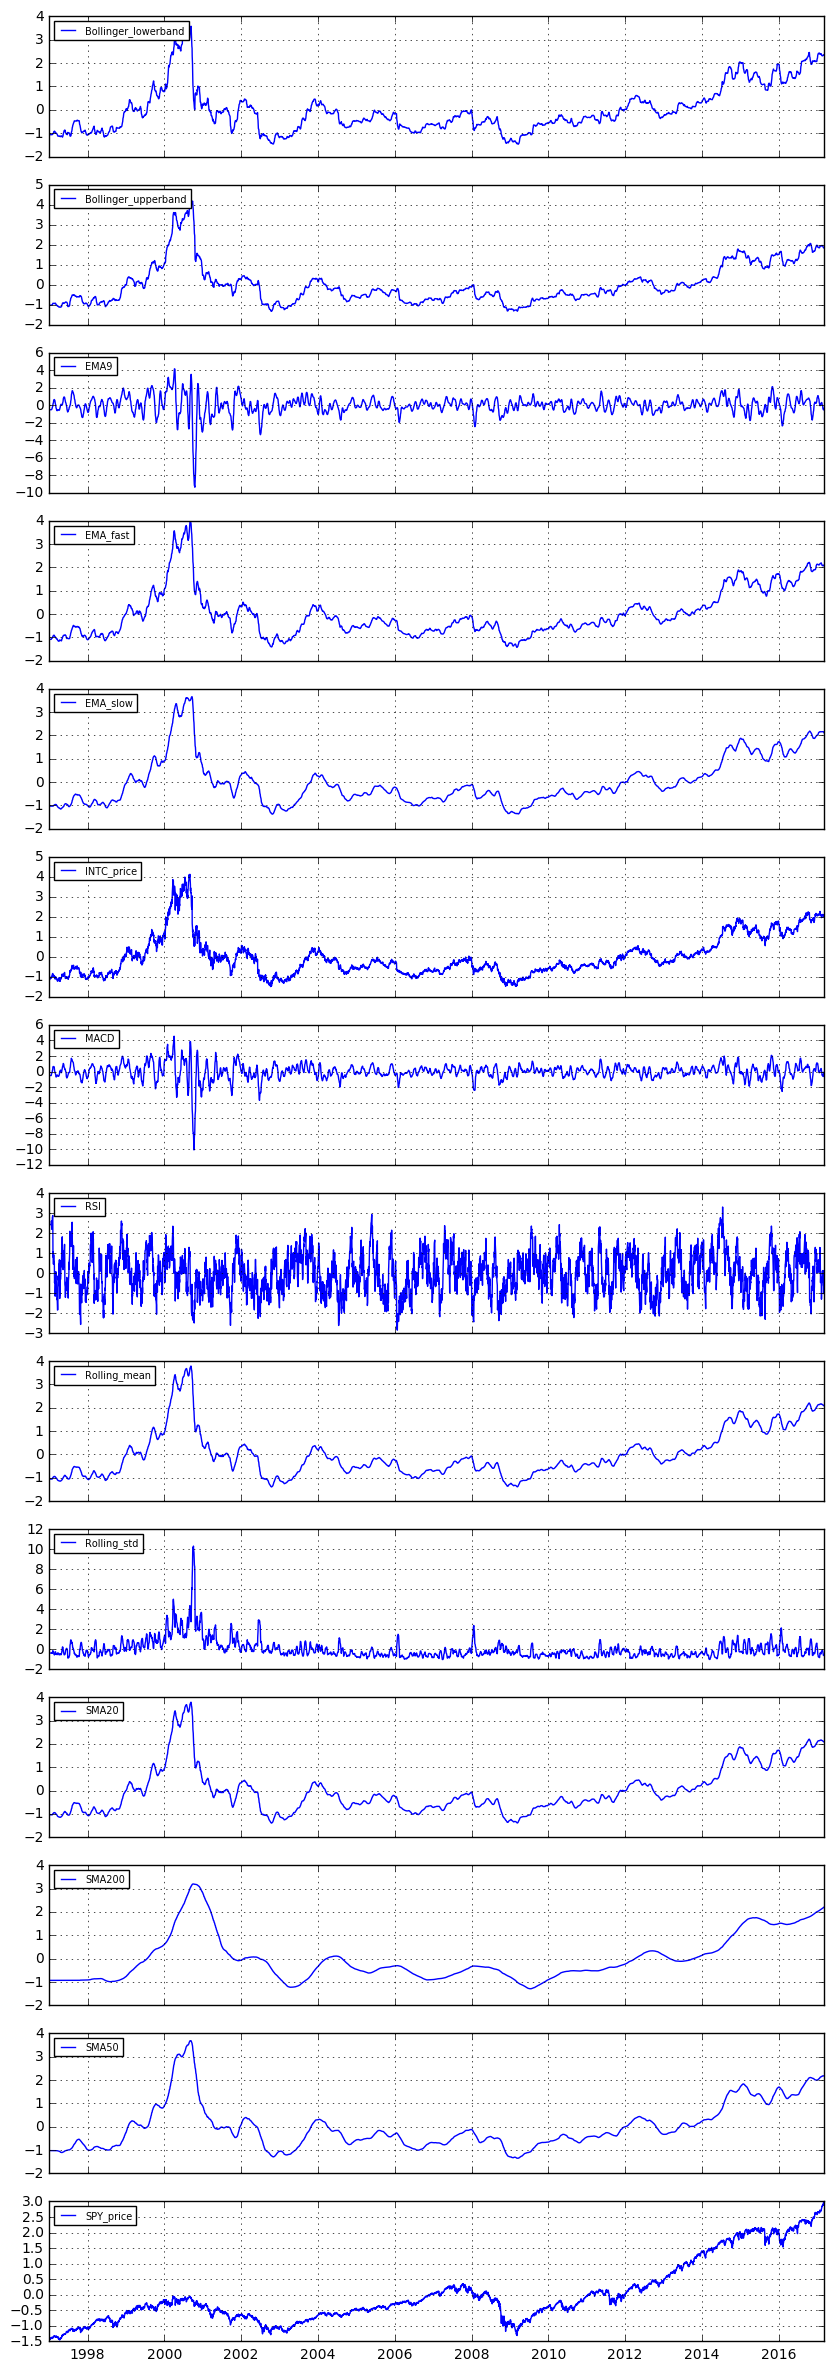

In [49]:
plt.rcParams['figure.figsize'] = (10.0, 30.0)
f, ax = plt.subplots(nrows=len(df_merged.columns),sharex=True) #

for i,colname in enumerate(df_merged.columns):
    ax[i].plot(df_merged[colname])
    ax[i].set_ylabel("")
    ax[i].grid(True)
    ax[i].legend(loc='upper left',fontsize=7)
plt.show()

In [51]:
#Split training-testset 

y = df_merged['INTC_price']
X = pd.DataFrame([  
                    df_merged['Bollinger_lowerband'], 
                    df_merged['Bollinger_upperband'], 
                    df_merged['EMA9'], 
                    df_merged['EMA_fast'],
                    df_merged['EMA_slow'],
                    df_merged['MACD'], 
                    df_merged['RSI'], 
                    df_merged['Rolling_mean'],
                    df_merged['Rolling_std'], 
                    df_merged['SMA20'], 
                    df_merged['SMA200'], 
                    df_merged['SMA50'], 
                    df_merged['SPY_price']
        
                 ]).transpose()

'''
                    df_merged['log_return_1day'],
                    
                    
                    df_merged['return_1day'] 
                    
                    df_merged['log_return_7day'],
                    df_merged['log_return_14day'], 
                    df_merged['log_return_28day'], 
                    df_merged['log_return_120day'], 
                    df_merged['log_return_365day'], 
                    
                    df_merged['return_7day']
                    df_merged['return_14day'], 
                    df_merged['return_28day'],
                    df_merged['return_120day'], 
                    df_merged['return_365day'], 
                    
                    df_merged['Intel 30-Day Average Daily Volume'],
                    df_merged['Intel Volume'],
                    
                    df_merged['Intel 14-Day Relative Strength Index'],
                    df_merged['Intel Accounts Payable (Annual)'], 
                    df_merged['Intel EBITDA (TTM)'],
                    df_merged['Intel EPS Basic (TTM)'], 
                    df_merged['Intel Enterprise Value'],
                    df_merged['Intel Gross Profit (Annual)'], 
                    df_merged['Intel Market Cap'],
                    df_merged['Intel Net Income (TTM)'], 
                    df_merged['Intel PE Ratio (TTM)'],
                    df_merged['Intel Quick Ratio (Quarterly)'], 
                    df_merged['Intel Total Assets (Quarterly)'],
                    df_merged['Intel Total Current Assets (Quarterly)'],
                    df_merged['Intel Total Return Price (Forward Adjusted)'], 
'''

tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X):
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X[:len(train_index)], X[len(train_index):(len(train_index)+len(test_index))]

print "X_train, y_train,X_test, y_test",X_train.shape, y_train.shape,X_test.shape, y_test.shape

display(X_train[:5])
display(y_train[:5])
print type(y_train)

X_train, y_train,X_test, y_test (3810, 13) (3810,) (1270, 13) (1270,)


,Bollinger_lowerband,Bollinger_upperband,EMA9,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
1997-01-02,-1.065017,-1.030221,-0.532325,-1.084894,-1.028715,-0.508046,2.418443,-1.056698,-0.389367,-1.039779,-0.932133,-1.025424,-1.446898
1997-01-03,-1.065017,-1.030221,-0.532325,-1.084894,-1.028715,-0.508046,2.418443,-1.056698,-0.389367,-1.039779,-0.932133,-1.025424,-1.429479
1997-01-06,-1.065017,-1.030221,-0.532325,-1.084894,-1.028715,-0.508046,2.418443,-1.056698,-0.389367,-1.039779,-0.932133,-1.025424,-1.440237
1997-01-07,-1.065017,-1.030221,-0.532325,-1.084894,-1.028715,-0.508046,2.418443,-1.056698,-0.389367,-1.039779,-0.932133,-1.025424,-1.425381
1997-01-08,-1.065017,-1.030221,-0.532325,-1.084894,-1.028715,-0.508046,2.418443,-1.056698,-0.389367,-1.039779,-0.932133,-1.025424,-1.436138


1997-01-02   -1.220982
1997-01-03   -1.130348
1997-01-06   -1.124684
1997-01-07   -1.073702
1997-01-08   -1.086448
Name: INTC_price, dtype: float64

<class 'pandas.core.series.Series'>


# Fit and predict, evaluate each regressor

In [52]:
regressor_RMSE={}

def train_predict_evaluate(regressor,X_train, y_train,X_test):
    regressor.fit(X_train, y_train)
    y_train_pred=regressor.predict(X_train)
    y_test_pred=regressor.predict(X_test)
   
    #Evaluation of regression
    print "\n****Evaluation of regression in testset****"
    Rsqr=regressor.score(X_test,y_test)
    RMSE=np.sqrt((np.sum((y_test_pred-y_test)**2))/len(y_test_pred))

    #R square=(1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
    #and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum()
    #R^2=coefficient of determination of the prediction in test set
    print "R^2 ==",Rsqr
    print "RMSE==",RMSE
    regressor_RMSE.update({regressor.__class__.__name__: RMSE})


    ##convert np array to df to plot together 
    df_train_pred = pd.DataFrame({'y_train_pred':y_train_pred}, index=y_train.index)
    df_train_pred.head(2)

    df_merged_trainPred=y_train.to_frame('INTC_price').join(df_train_pred)
    df_merged_trainPred.head(2)

    #Plot 
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    ax1=df_merged_trainPred.plot()
    ax1.set_xlabel('date',fontsize=12)
    ax1.set_ylabel("adj.close price",fontsize=12)
    ax1.set_title('Trainset model vs. data')
    ax1.grid(True)
    ax1.legend(loc="best", fontsize=14)

    #Check testset data vs. prediction
    df_test_pred = pd.DataFrame({'y_test_pred':y_test_pred}, index=y_test.index)
    df_test_pred.head(2)
    df_merged_testPred=y_test.to_frame('INTC_price').join(df_test_pred)
    df_merged_testPred.head(2)

    ax2=df_merged_testPred.plot()
    ax2.set_xlabel('date',fontsize=12)
    ax2.set_ylabel("adj.close price",fontsize=12)
    ax2.set_title('Testset model vs. data')
    ax2.grid(True)
    ax2.legend(loc="best", fontsize=14)

### Base model: knn regressor


****Evaluation of regression in testset****
R^2 == 0.704028791053
RMSE== 0.415375550871


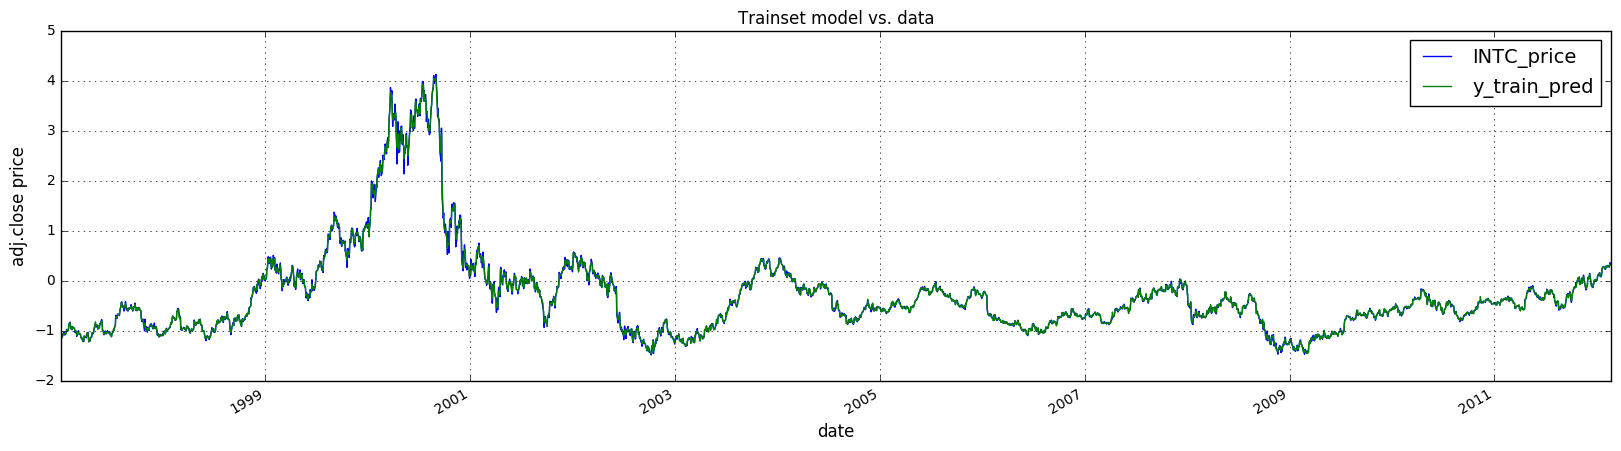

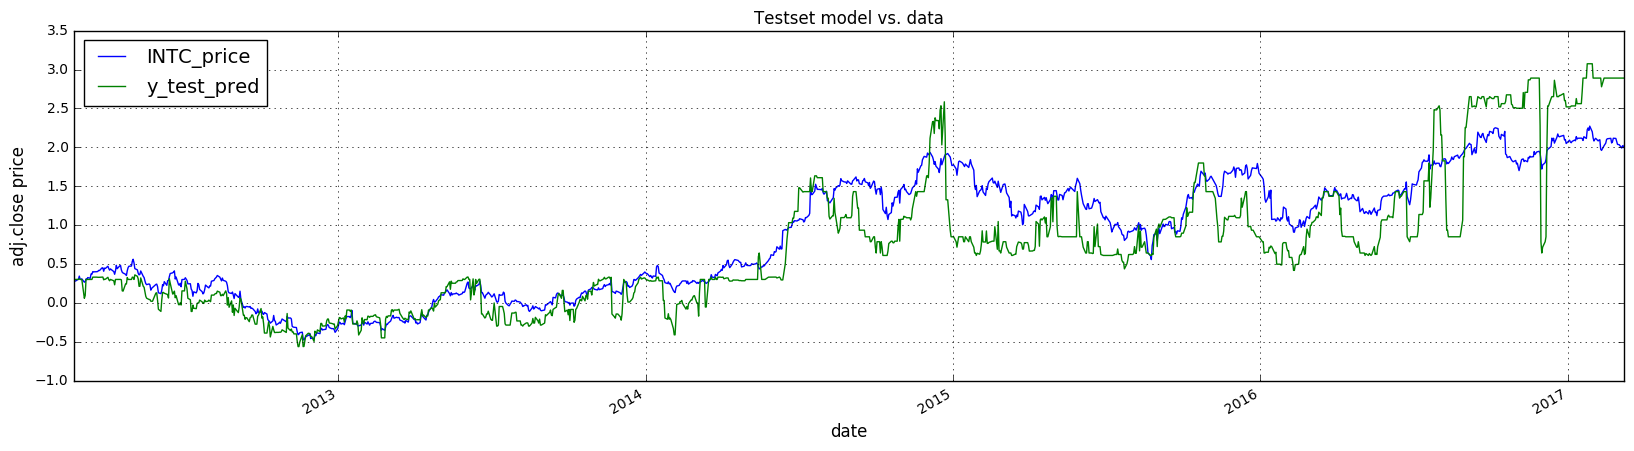

In [53]:
#Baseline model, knn regressor

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=3)

train_predict_evaluate(regressor,X_train, y_train, X_test)

##### baseline knn shows poor performance. 


### RandomForest


****Evaluation of regression in testset****
R^2 == 0.583139889214
RMSE== 0.49295964342


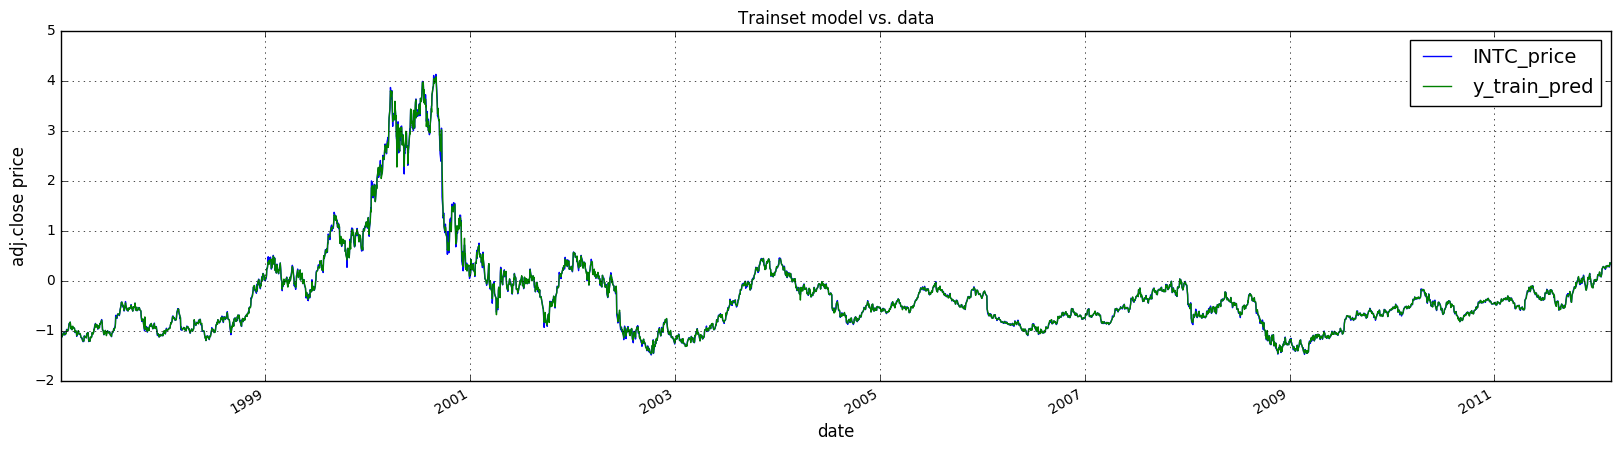

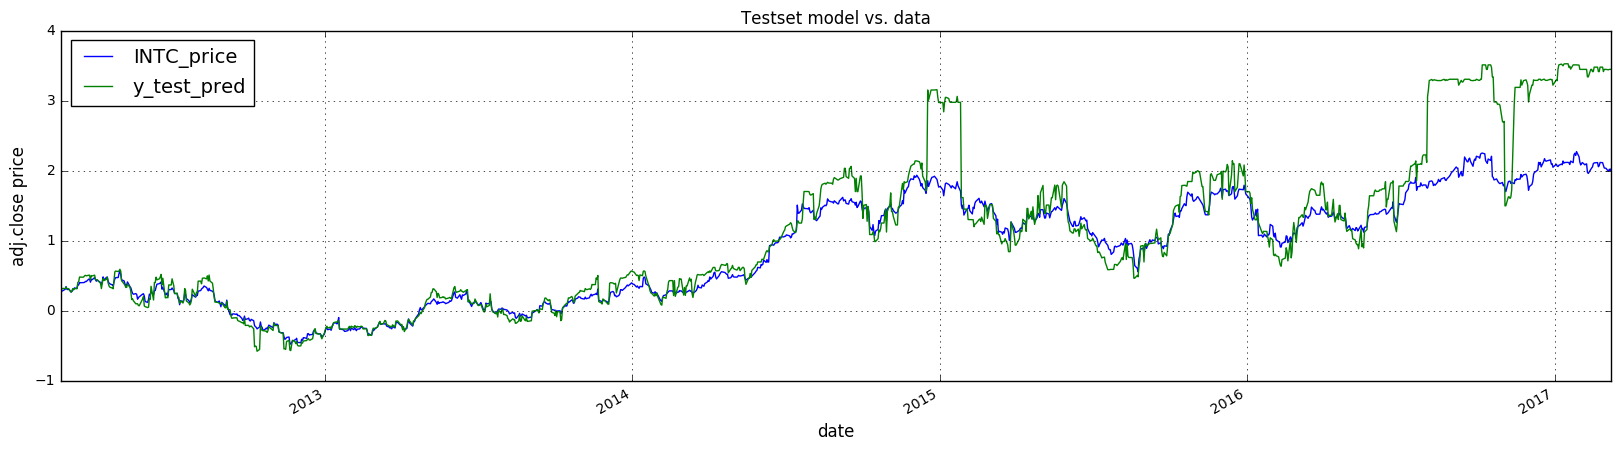

In [54]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
train_predict_evaluate(regressor,X_train, y_train,X_test)

In [55]:
#feature importance in rank
feat_imprt=regressor.feature_importances_
features=np.array(X_train.columns)
featTable=np.vstack((features,feat_imprt))
featTable
ft=pd.DataFrame(featTable.T,columns=['features','values'])
ft.sort_values(by='values',ascending=False)

,features,values
3,EMA_fast,0.772996
0,Bollinger_lowerband,0.195636
6,RSI,0.014719
12,SPY_price,0.00686278
1,Bollinger_upperband,0.00410389
10,SMA200,0.00104418
11,SMA50,0.00101978
9,SMA20,0.000787752
8,Rolling_std,0.000742768
7,Rolling_mean,0.000733651


### Adaboost with Decision tree

### Decision tree first 


****Evaluation of regression in testset****
R^2 == 0.623174825713
RMSE== 0.468690500622


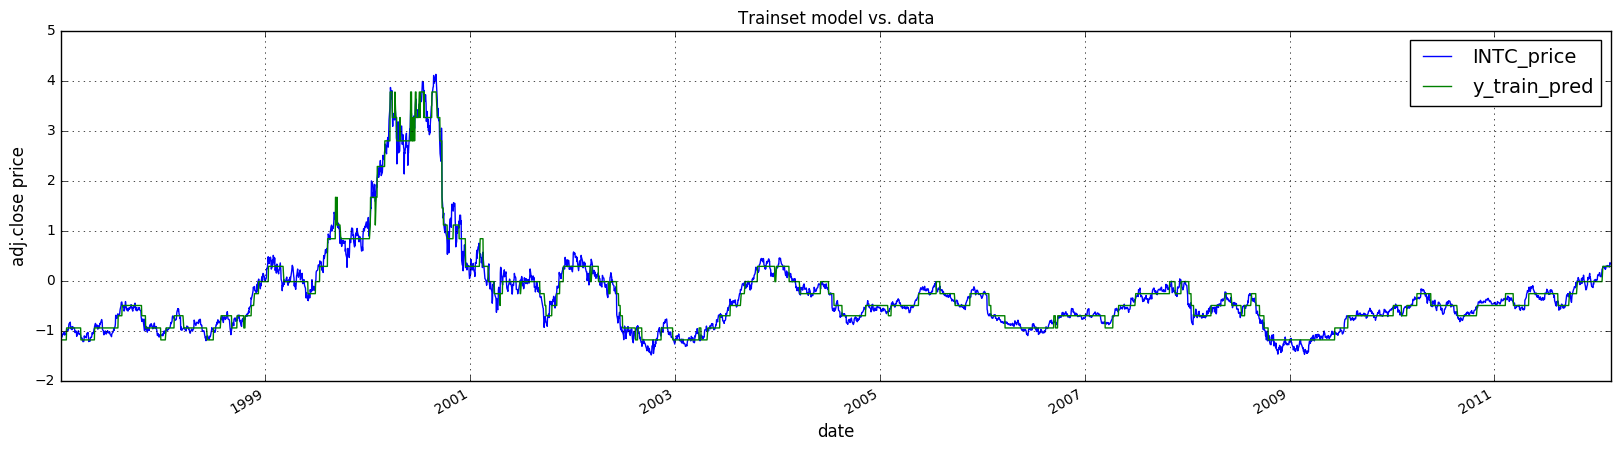

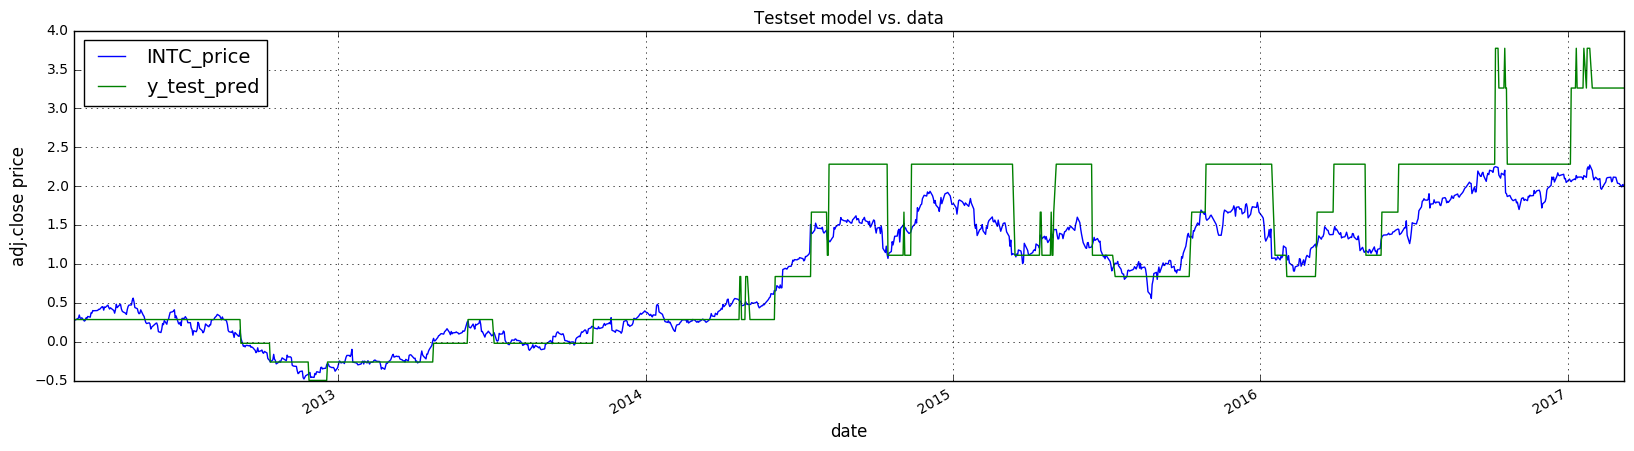

In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)
regressor= DecisionTreeRegressor(max_depth=4)

#Decision tree first
train_predict_evaluate(regressor,X_train, y_train,X_test)

### AdaBoost


****Evaluation of regression in testset****
R^2 == 0.795308028752
RMSE== 0.345435208703


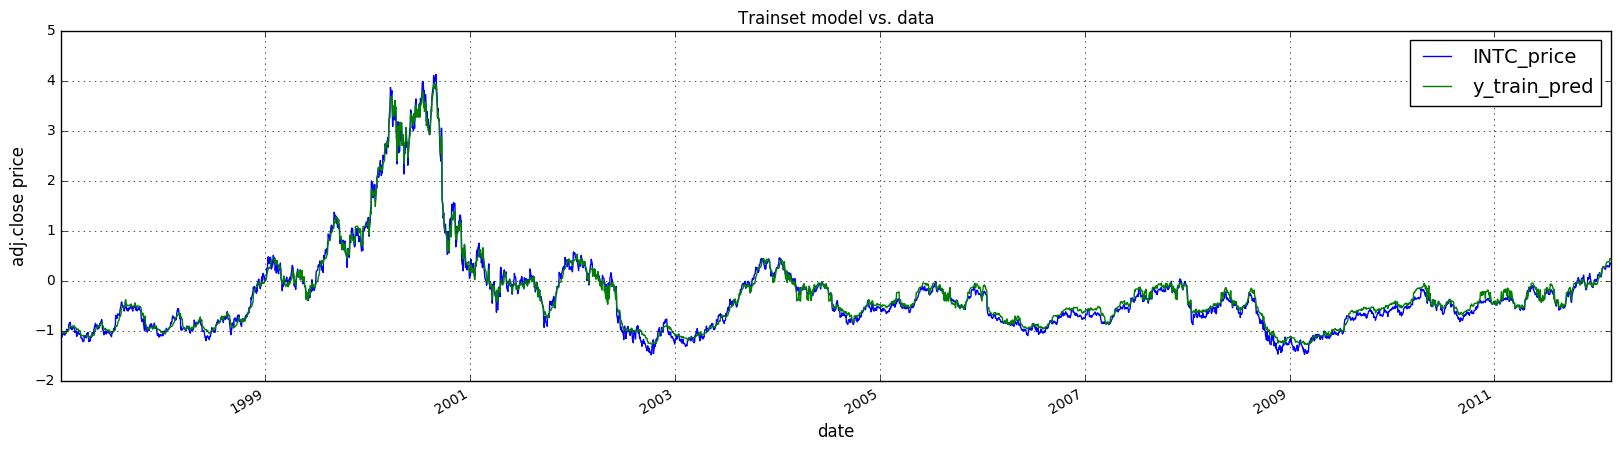

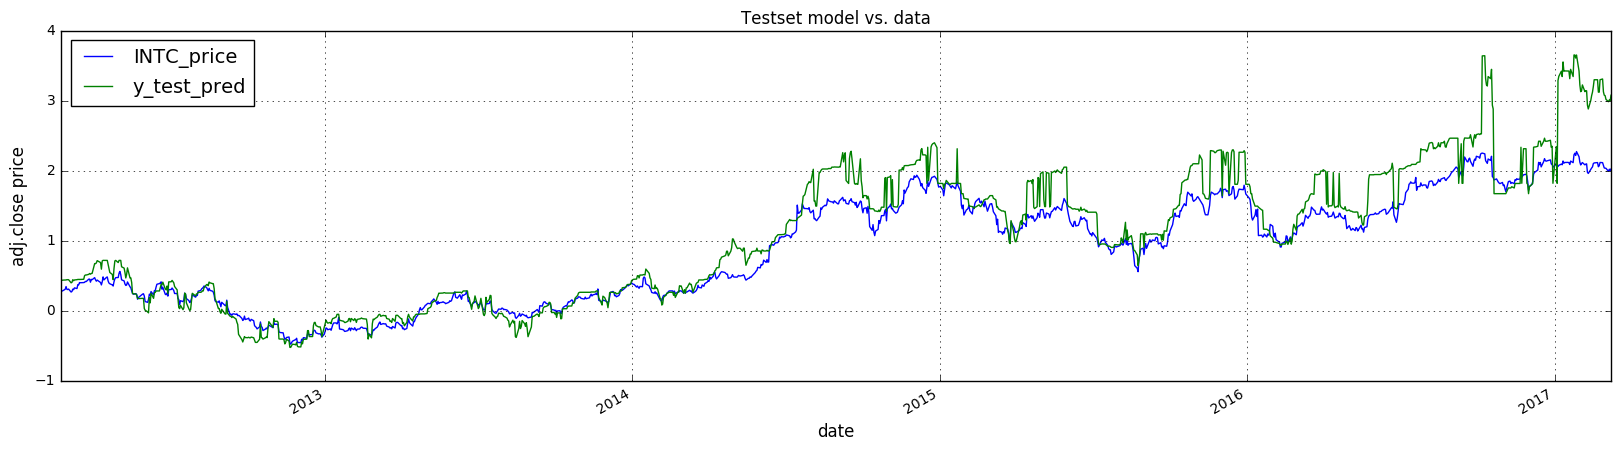

In [57]:
regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

train_predict_evaluate(regressor,X_train, y_train,X_test)

### SVM


****Evaluation of regression in testset****
R^2 == 0.937369684218
RMSE== 0.191077036825


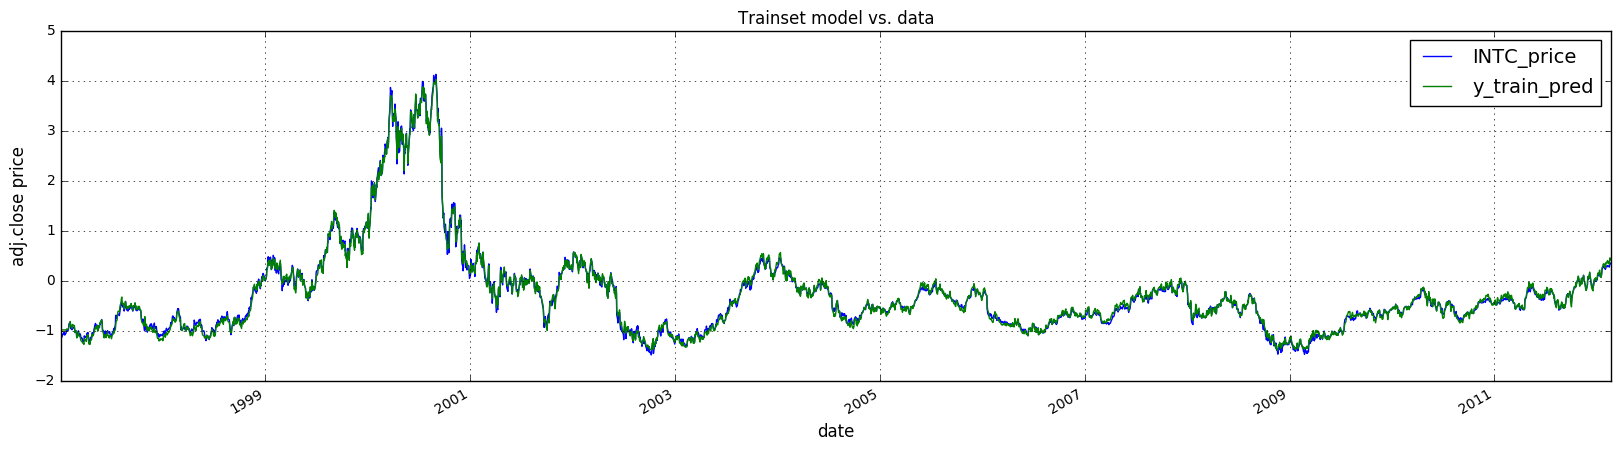

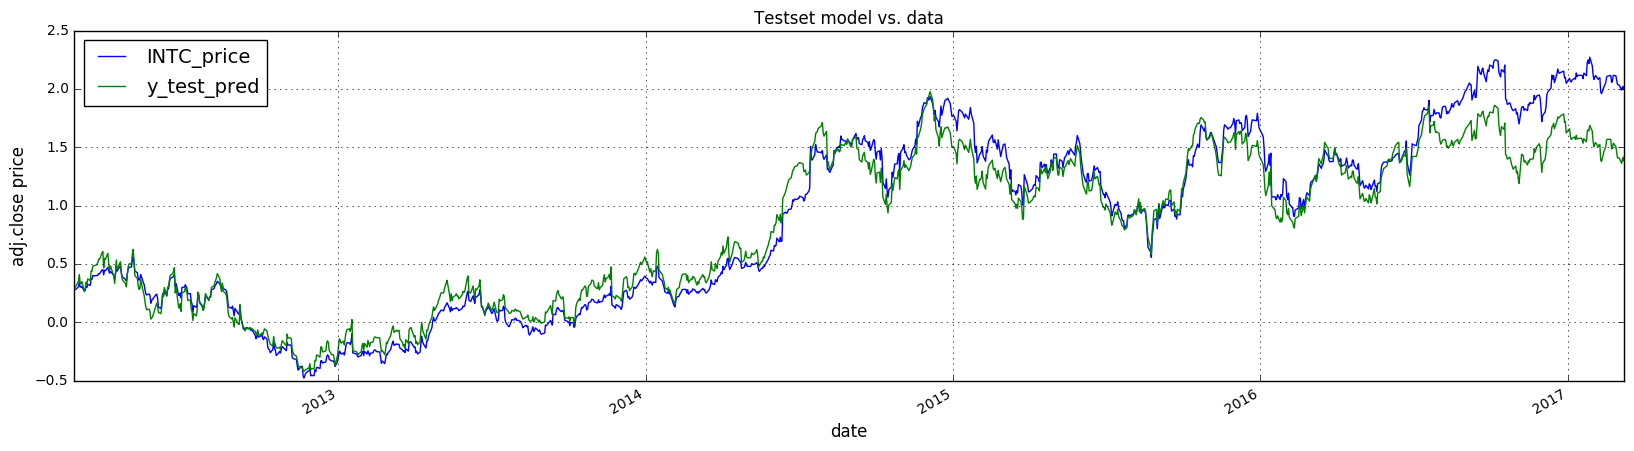

In [58]:
from sklearn.svm import SVR

np.random.seed(0)
regressor= SVR()#C=1.0, epsilon=0.2

train_predict_evaluate(regressor,X_train, y_train,X_test)

,regressor,RMSE
2,SVR,0.191077
3,AdaBoostRegressor,0.345435
1,KNeighborsRegressor,0.415376
0,DecisionTreeRegressor,0.468691
4,RandomForestRegressor,0.492960


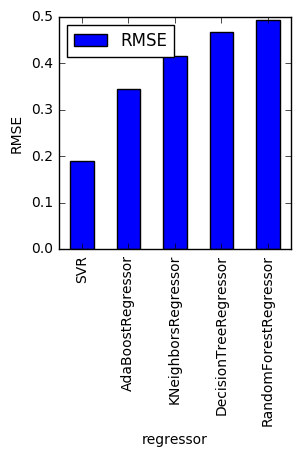

In [59]:
#summary of RMSE for all regressors
plt.rcParams['figure.figsize'] = (3.0, 3.0)
regressor_RMSE_df=pd.DataFrame(list(regressor_RMSE.iteritems()), columns=['regressor','RMSE'])

regressor_RMSE_df=regressor_RMSE_df.sort_values(by=['RMSE'],ascending=True)
display(regressor_RMSE_df)

ax=regressor_RMSE_df.plot(x=regressor_RMSE_df['regressor'],kind='bar')
ax.set_ylabel('RMSE')

# forcasting with ARIMA model

In [26]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from pandas.tools.plotting import autocorrelation_plot

### testing stationary, checking lag

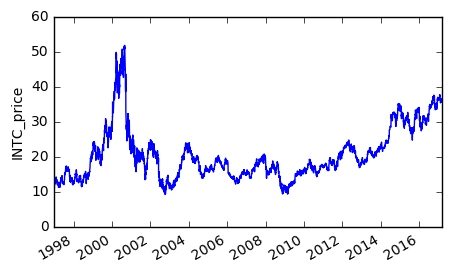

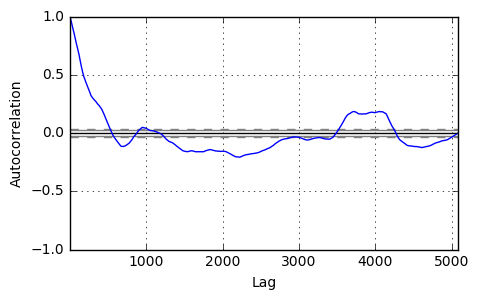

ADF Statistic: -1.962307
p-value: 0.303341
Critical Values:
	5%: -2.862
	1%: -3.432
	10%: -2.567


In [27]:
series=df_merged['INTC_price']

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('INTC_price')
plt.show()

# autocorrelation plot
autocorrelation_plot(series)
plt.show()

# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

Test statistic value was -1.962307. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series appears to be **"non-stationary"** with a low likelihood of the result being a statistical fluke.

### Make indicator as stationary by taking return

df_price["Return_1day"]=prices/prices.shift(1)-1
df_price["Return_7day"]=prices/prices.shift(7)-1
df_price["Return_14day"]=prices/prices.shift(14)-1
df_price["Return_28day"]=prices/prices.shift(28)-1
df_price["Return_120day"]=prices/prices.shift(120)-1
df_price["Return_365day"]=prices/prices.shift(365)-1

df_price["log_Return_1day"]=np.log(df_price["Return_1day"])
df_price["log_Return_7day"]=np.log(df_price["Return_7day"])
df_price["log_Return_14day"]=np.log(df_price["Return_14day"])
df_price["log_Return_28day"]=np.log(df_price["Return_28day"])
df_price["log_Return_120day"]=np.log(df_price["Return_120day"])
df_price["log_Return_365day"]=np.log(df_price["Return_365day"])

df_price.fillna(0,inplace=True)

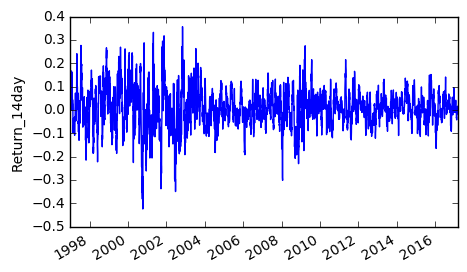

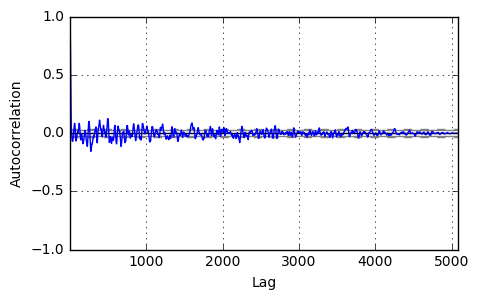

ADF Statistic: -10.678698
p-value: 0.000000
Critical Values:
	5%: -2.862
	1%: -3.432
	10%: -2.567


In [28]:
series=df_price["Return_14day"]

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('Return_14day')
plt.show()

# autocorrelation plot
autocorrelation_plot(series)
plt.show()

# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

14-day return is now stationary. 

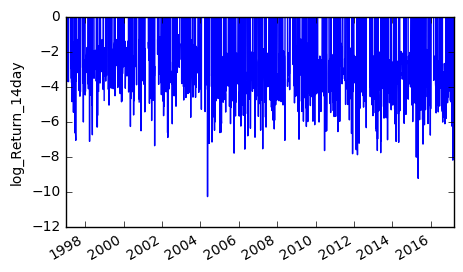

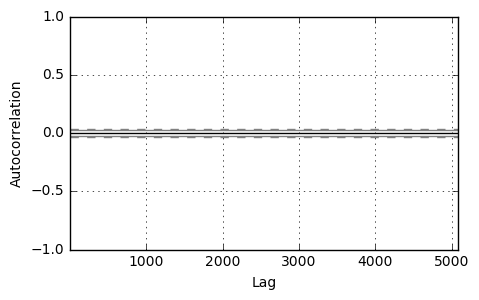

"\n# statistical test #The null hypothesis of the test is that the time series is non-stationary.\nresult = adfuller(series) \nprint('ADF Statistic: %f' % result[0])\nprint('p-value: %f' % result[1])\nprint('Critical Values:')\nfor key, value in result[4].items():\n    print('\t%s: %.3f' % (key, value))\n"

In [29]:
series=df_price["log_Return_14day"]

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('log_Return_14day')
plt.show()

# autocorrelation plot
autocorrelation_plot(series)
plt.show()

'''
# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
'''

### residual after a simple model

In [30]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
ax=residuals.plot(title='residuals')
ax.set_ylabel('residual')
plt.show()

# density plot of residuals
residuals.plot(kind= 'kde', title='density plot' )
plt.show()

# summary stats of residuals
print(residuals.describe())

LinAlgError: Array must not contain infs or NaNs

In [60]:
#Forcasting

X = df_merged['INTC_price'][:30]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    observ = test[t]
    history.append(observ)
    print( 'predicted=%f, expected=%f'  % (yhat, observ))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print( 'Test RMSE: %.3f'  % rmse)


predicted=-0.974285, expected=-0.944252
predicted=-0.927973, expected=-0.883337
predicted=-0.858150, expected=-0.859255
predicted=-0.840293, expected=-0.840839
predicted=-0.822828, expected=-0.830922
predicted=-0.814642, expected=-0.915920
predicted=-0.921281, expected=-0.962668
predicted=-0.971589, expected=-0.925836
predicted=-0.907046, expected=-0.979667
predicted=-0.981865, expected=-0.978251
predicted=-0.970381, expected=-0.921586
Test RMSE: 0.047


,pred_y,test_y
1997-01-29,-0.974285,-0.944252
1997-01-30,-0.927973,-0.883337
1997-01-31,-0.858150,-0.859255
1997-02-03,-0.840293,-0.840839
1997-02-04,-0.822828,-0.830922
1997-02-05,-0.814642,-0.915920
1997-02-06,-0.921281,-0.962668
1997-02-07,-0.971589,-0.925836
1997-02-10,-0.907046,-0.979667
1997-02-11,-0.981865,-0.978251


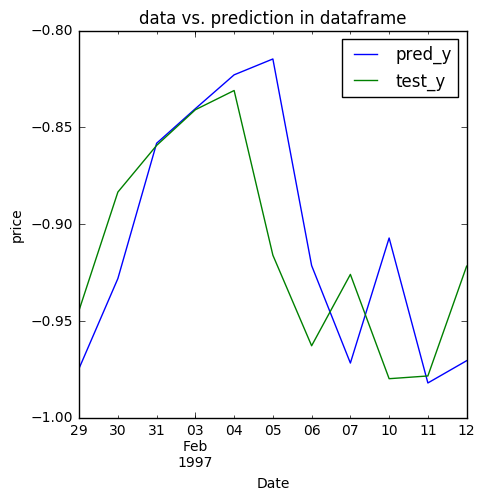

In [61]:
#Deal with dataframe and plot pred vs. test data
plt.rcParams['figure.figsize'] = (5.0, 5.0)

test_y = pd.DataFrame({'test_y':test}, index=test.index)
prediction_y=pd.Series( (v[0] for v in predictions))
prediction_y_df=pd.DataFrame({'pred_y':[v[0] for v in predictions]},  index=test.index)

test_pred_y=prediction_y_df.join(test_y)
display(test_pred_y)
ax=test_pred_y.plot(title='data vs. prediction in dataframe')
ax.set_ylabel('price')
ax.set_xlabel('Date')
plt.show()